In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

In [1]:
import torchio as tio
from pathlib import Path
from unet import UNet
import numpy as np
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
#from monai.networks.nets import UNet

In [2]:
#!pip install unet
#!pip install torchio

In [48]:
MAIN_TYPE='flair'

In [49]:
PATH_TO_DIR=r'D:\Datasets\brats_dataset\BraTS2021_Training_Data/'

In [50]:
subjects_list =[]

In [51]:
for subject_id in Path(PATH_TO_DIR).iterdir():
    image_path =""
    segmentation_path =""
    if subject_id.is_dir():
        for elem in subject_id.iterdir():
            if MAIN_TYPE in str(elem):
                image_path =elem
            if 'seg' in str(elem):
                segmentation_path=elem
        subject = tio.Subject(
            t1=tio.ScalarImage(image_path),
            seg=tio.LabelMap(segmentation_path))
        subjects_list.append(subject)

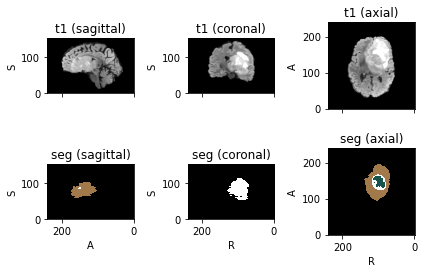

In [52]:
subjects_list[0].plot()

In [53]:
from matplotlib import pyplot as plt

In [57]:
img_slice =subject['t1'][tio.DATA].numpy().squeeze()[:,:,106]

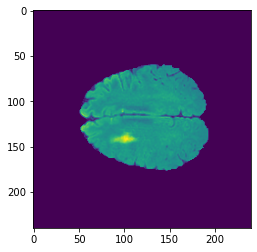

In [58]:
plt.imshow(img_slice)

In [59]:
mask_slice =subject['seg'][tio.DATA].numpy().squeeze()[:,:,106]

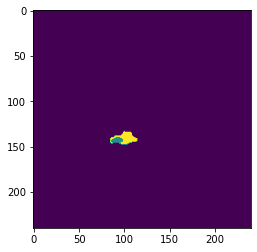

In [60]:
plt.imshow(mask_slice)

In [13]:
np.unique(subject['seg'][tio.DATA].numpy())

array([0, 1, 2], dtype=uint8)

In [14]:
torch.cuda.is_available()

True

In [15]:
subjects_train, subjects_val =train_test_split(subjects_list,test_size=0.2,shuffle =True)

In [16]:
queue_length =180
samples_per_volume =6
patch_size =112

In [17]:
class LabelConvertBRats(tio.LabelTransform):
    def __init__(
                self,
                **kwargs
                ):
            super().__init__(**kwargs)
            self.kwargs = kwargs

    def apply_transform(self, subject):
            for image in self.get_images(subject):
                
                # merge label 2 and label 3 to construct TC
                data_tc =np.where((image.data == 2) | (image.data == 4), 1, 0)
                # merge labels 1, 2 and 3 to construct WT
                data_wt =np.where((image.data == 2) | (image.data == 4)  | (image.data == 1), 1, 0)
                
                # label 2 is ET
                data_et =np.where(image.data == 2,1,0)
                
                new_data =np.stack([data_wt.squeeze(), data_tc.squeeze(),data_et.squeeze()], axis=0)
                del data_wt, data_tc, data_et
                new_data = new_data.astype(np.float32)
                image.set_data(new_data)
            return subject

    def is_invertible(self):
            # Not always, as explained in the docstring
            return True


In [18]:
train_transform =tio.Compose([tio.ZNormalization(masking_method=tio.ZNormalization.mean), LabelConvertBRats()])
validation_transform =tio.Compose([tio.ZNormalization(masking_method=tio.ZNormalization.mean), LabelConvertBRats()])

In [19]:
# train_transform =tio.Compose([tio.ZNormalization(masking_method=tio.ZNormalization.mean)])
# validation_transform =tio.Compose([tio.ZNormalization(masking_method=tio.ZNormalization.mean)])

In [20]:
training_set = tio.SubjectsDataset(
                subjects_train, transform=train_transform)

validation_set = tio.SubjectsDataset(
                subjects_val, transform=validation_transform)

In [21]:
tsk1=training_set[0]

In [22]:
mask_slice0 =tsk1['seg'][tio.DATA].numpy()[0,:,:,65]

In [23]:
np.unique(mask_slice0)

array([0., 1.], dtype=float32)

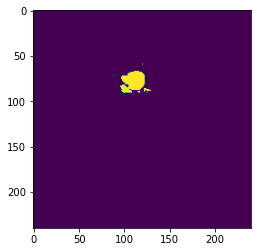

In [24]:
plt.imshow(mask_slice0)

In [25]:
mask_slice1 =tsk1['seg'][tio.DATA].numpy()[1,:,:,65]

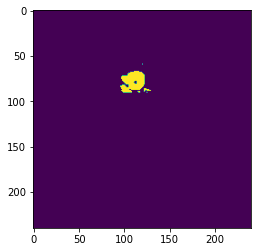

In [26]:
plt.imshow(mask_slice1)

In [27]:
mask_slice2 =tsk1['seg'][tio.DATA].numpy()[2,:,:,65]

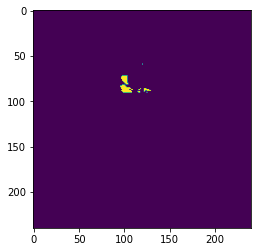

In [28]:
plt.imshow(mask_slice2)

In [29]:
patches_train= tio.Queue(
    training_set,
    queue_length,
    samples_per_volume,
    sampler=tio.sampler.UniformSampler(patch_size),
    num_workers=0,
    shuffle_subjects=True,
    shuffle_patches=True
)

patches_val= tio.Queue(
    validation_set,
    queue_length,
    samples_per_volume,
    sampler=tio.sampler.UniformSampler(patch_size),
    num_workers=0,
    shuffle_subjects=False,
    shuffle_patches=False,
)

In [30]:
train_loader = DataLoader(patches_train, batch_size=4, num_workers=0)
val_loader = DataLoader(patches_val, batch_size=1, num_workers=0)

In [31]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

In [32]:
from surface_distance import metrics
from tqdm import tqdm

def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
    
    return tp/(tp+fn), tn/(tn+fp)


def calculate_metrics_brats(true_mask, pred_mask):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Dice_ET', 'Dice_TC', 'Dice_WT',
               'Hausdorff95_ET', 'Hausdorff95_TC', 'Hausdorff95_WT',
               'Sensitivity_ET', 'Sensitivity_TC', 'Sensitivity_WT',
               'Specificity_ET', 'Specificity_TC', 'Specificity_WT',
               'Surface_dice_ET', 'Surface_dice_TC', 'Surface_dice_WT']
    
    df ={}
    #ET
    distances = metrics.compute_surface_distances((true_mask[:,2,:,:]), (pred_mask[:,2,:,:]), [1,1,1])
    df['Dice_ET'] = metrics.compute_dice_coefficient((true_mask == 1), (pred_mask == 1))
    df['Surface_dice_ET'] = metrics.compute_surface_dice_at_tolerance(distances, 1)
    df['Hausdorff95_ET'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, spec = sensitivity_and_specificity((true_mask == 1), (pred_mask == 1))
    df['Sensitivity_ET'] = sens 
    df['Specificity_ET'] = spec
    #TC
    distances = metrics.compute_surface_distances((true_mask == 2), (pred_mask == 2), [1,1,1])
    df['Dice_TC'] = metrics.compute_dice_coefficient((true_mask == 2), (pred_mask == 2))
    df['Surface_dice_TC'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df['Hausdorff95_TC'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, spec = sensitivity_and_specificity((true_mask == 2), (pred_mask == 2))
    df['Sensitivity_TC'] = sens
    df['Specificity_TC'] = spec
    #WT
    distances = metrics.compute_surface_distances((true_mask == 3), (pred_mask == 3), [1,1,1])
    df['Dice_WT'] = metrics.compute_dice_coefficient((true_mask == 3), (pred_mask == 3))
    df['Surface_dice_WT'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df['Hausdorff95_WT'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, spec= sensitivity_and_specificity((true_mask == 3), (pred_mask == 3))
    df['Sensitivity_WT'] = sens
    df['Specificity_WT'] = spec
    return df

In [33]:
MRI =MAIN_TYPE
LABEL ='seg'
DATA ="data"

In [34]:
# model = UNet(spatial_dims=3,
#                           in_channels=1,
#                           out_channels=3,
#                           channels=(32, 64, 128, 256),
#                           strides=(2, 2, 2))

In [35]:
batch =next(iter(val_loader))

In [37]:
class Unet3D(pl.LightningModule):
    
    def __init__(self, params,validation_set, unet_type ="default"):
        super().__init__()
        if unet_type =="monai":
            self.model = UNet(spatial_dims=3,
                          in_channels=1,
                          out_channels=3,
                          channels=(32, 64, 128, 256),
                          strides=(2, 2, 2),)
        else:    
            self.model =UNet(
                        in_channels=1,
                        out_classes=3,
                        dimensions=3,
                        num_encoding_blocks=3,
                        out_channels_first_layer=8,
                        normalization='batch',
                        upsampling_type='linear',
                        padding=True,
                        activation='PReLU',
            )
        self.loss = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
        self.params =params
        self.validation_set =validation_set

    def forward(self, x):
        out = self.model(x)
        return out
    
    def prepare_batch(self, batch):
        return batch[MRI][DATA], batch[LABEL][DATA]
    
    def training_step(self, batch, batch_idx):
        inputs, targets = self.prepare_batch(batch)
        logits = self.model(inputs)
        loss = self.loss(logits, targets)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return {"loss": loss , "targets" : targets, "logits" : logits}
    
    def validation_step(self, batch, batch_idx):
        inputs, targets = self.prepare_batch(batch)
        logits = self.model(inputs)
        loss = self.loss(logits, targets)
        self.log('valid_loss', loss, on_epoch=True, on_step=True, prog_bar=True)
        return {"loss": loss , "targets" : targets, "logits" : logits, "inputs" : inputs}
    
            
            
    def validation_epoch_end(self, outputs):
        
        outputs =self.evaluate(self.validation_set, outputs[0]['inputs'])
        
#         img = torch.cat(outputs['inputs']).cpu()
#         pred = torch.cat(outputs['predictions']).cpu()
#         mask = torch.cat(outputs['targets']).cpu()
        
#         log_dict =calculate_metrics_brats(mask, pred)

#         for k, v in log_dict.items():
#             self.log(k, v, prog_bar=True)
    
        # Visualize results

        #pred_vis = self.visualize_mask(torch.argmax(pred, dim=1))
        #mask_vis = self.visualize_mask(mask)
#         for i in range(0,3):
#             slice1 =img.shape[-1]//2
#             results = torch.cat(torch.cat([img[:,i,:,:,slice1], pred_vis[:,i,:,:,slice1], mask_vis[:,i,:,:,slice1]], dim=3).split(1, dim=0), dim=2)
#             results_thumbnail = F.interpolate(results, scale_factor=0.25, mode='bilinear')[0]

#             self.logger.experiment.add_image(f'results_{i}', results_thumbnail, self.current_epoch)
        
    
    
        
    def evaluate(self, evaluation_set,img):
        samples =[]
        all_tragets =[]
        all_predictions =[]
        
        for i in tqdm(range(len(evaluation_set)), leave=False):
            sample = evaluation_set[i]
            targets = sample[LABEL][DATA]
            grid_sampler = tio.inference.GridSampler(
                sample,
                self.params["patch_size"],
            )
            patch_loader = torch.utils.data.DataLoader(
                grid_sampler, batch_size=self.params["validation_batch_size"], num_workers=0)
            aggregator = tio.inference.GridAggregator(grid_sampler)
    
            for patches_batch in patch_loader:
                    inputs = patches_batch[MRI][DATA].type_as(img)
                    locations = patches_batch['location']
                    logits = self.model(inputs)
                    labels = logits.argmax(dim=1, keepdim=True).int()
                    aggregator.add_batch(labels, locations)
            predictions = aggregator.get_output_tensor()
            
            samples.append(sample)
            all_tragets.append(targets)
            all_predictions.append(predictions)
            
        return  {"inputs": samples , "targets" : all_tragets, "predictions" : all_predictions}   
            
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.params["learning_rate"], weight_decay=self.params["weight_decay"])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.params["max_epochs"])
        return ([optimizer], [scheduler])

In [38]:
params ={"learning_rate": 1e-4,
         "weight_decay":1e-5,
         "max_epochs":300,
         "patch_size": patch_size,
         "patch_overlap":(0, 0, 0),
         "validation_batch_size" : 1
        }

In [39]:
assignment_dir = 'brain_segmentation'
experiment_name ="unet3_pathes"

checkpoint_callback = pl.callbacks.ModelCheckpoint(
        monitor='valid_loss',
        dirpath=f'{assignment_dir}/logs/{experiment_name}',
        filename='{epoch:02d}-{val_mean_iou:.3f}',
        mode='max')
    
logger = pl.loggers.TensorBoardLogger(save_dir=f'{assignment_dir}/logs', name=experiment_name)

In [40]:
pl_model =Unet3D(params,validation_set)

In [41]:
trainer = pl.Trainer(
    max_epochs=20,
    gpus=1, 
    benchmark=True, 
    check_val_every_n_epoch=5,
    logger=logger,
    callbacks=[checkpoint_callback])

trainer.fit(pl_model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\User\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:608: UserWarning: Checkpoint directory C:\Users\User\Documents\Сколково учеба\project\brain_segmentation\logs\unet3_pathes exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | UNet     | 246 K 
1 | loss  | DiceLoss | 0     
-----------------------------------
246 K     Trainable params
0         Non-trainable params
246 K     Total params
0.985     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\User\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\User\anaconda3\lib\site-packages\unet\decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2
C:\Users\User\anaconda3\lib\site-packages\pytorch_lightning\utilities\data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguou

MemoryError: Unable to allocate 102. MiB for an array with shape (3, 240, 240, 155) and data type int32